In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import binarize
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/gokul/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gokul/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data Initialization

In [2]:
# features info : https://goo.gl/p8ocBn
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

In [3]:
# initialization of the Dataset
data = pd.read_csv('pima-indians-diabetes.data', names=col_names)

In [4]:
# checking if there is not empty fields (SKL require none empty field)
data.count()

pregnant    768
glucose     768
bp          768
skin        768
insulin     768
bmi         768
pedigree    768
age         768
label       768
dtype: int64

In [5]:
data.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Selecting & Splitting the Dataset

In [6]:
# selection of relevant features
label = data['label']
data.drop('label', axis=1, inplace=True)

X, y = data, label

## Null Accuracy (also known as Dumb Model)

In [7]:
# distributing our Dataset into a training and testing distribution
# we use the default SKL split (0.75 (75%) for training)
# random_state=0 Setting the random seed (for reproductibility purpose)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
# counting the split of Positive (1) and Negative (0) labels in our testing distribution
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [9]:
# The mean of our testing distribution
# '1-' will allow us to return the max value
1- y_test.mean()

0.6770833333333333

## Machine Learning Model

### Best parameters evaluation with Grid Search Cross Validation

In [10]:
%%time
# Magic keyword time who display the cpu usage
# GridSearch procedure = cpu demanding
gradient_boost_eval = GradientBoostingClassifier(random_state=0)

params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(gradient_boost_eval, params, cv=10, scoring='roc_auc')
grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 0.5}
0.8338228573124407
CPU times: user 24.7 s, sys: 124 ms, total: 24.8 s
Wall time: 25.2 s


In [11]:
# GBC belong to the Random Tree Classifier family
# a complex model who perform well on small Dataset
# We set our hyper-params with the best params providing by GridSearch
gradient_boost = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, max_features=0.5, random_state=0)

#Cross Validation handle the .fit and .predict method
cross_val_score(gradient_boost, X, y, cv=10, scoring='roc_auc').mean()

0.83383190883190872

### Adjusting the Threshold for improvement

In [12]:
gradient_boost_imp = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, max_features=0.5, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gradient_boost_imp.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [13]:
# Storing the predicted probabilities of classification
y_pred_prob = gradient_boost_imp.predict_proba(X_test)[:, 1]

Text(0,0.5,'Frequency')

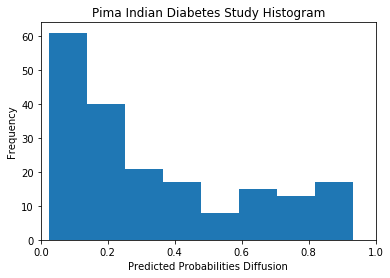

In [14]:
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Pima Indian Diabetes Study Histogram')
plt.xlabel('Predicted Probabilities Diffusion')
plt.ylabel('Frequency')

In [15]:
# Adjusting the threshold to 0.1
y_pred_class = binarize([y_pred_prob], 0.1)[0]

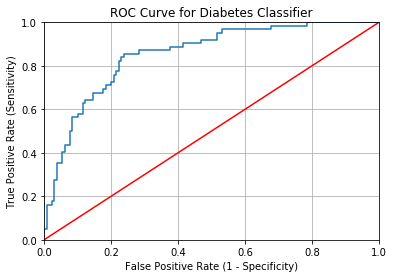

In [16]:
# Data Visualisation of ROC curve :
# equilibrium between True (tpr) and False (fpr) Positive Rate

import numpy as np
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for Diabetes Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Classifier Score

In [17]:
# level of predictive precision
roc_auc_score(y_test, y_pred_prob)

0.85248138957816377